In [17]:
!ls /kaggle/input/celeba-dataset


img_align_celeba      list_bbox_celeba.csv     list_landmarks_align_celeba.csv
list_attr_celeba.csv  list_eval_partition.csv


In [18]:
!ls /kaggle/input/


celeba-dataset


In [20]:
!ls /kaggle/input/celeba-dataset



img_align_celeba      list_bbox_celeba.csv     list_landmarks_align_celeba.csv
list_attr_celeba.csv  list_eval_partition.csv


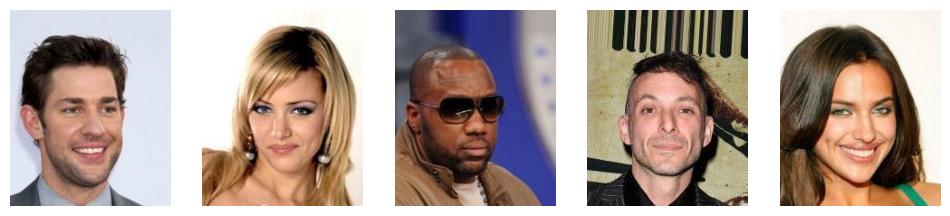

In [28]:
import matplotlib.pyplot as plt
from PIL import Image

# Show first 5 images
plt.figure(figsize=(12,6))
for i, img_name in enumerate(files[:5]):
    img_path = os.path.join(data_root, img_name)
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()


In [5]:
# Cell 1: imports and config
import os
from pathlib import Path
import math
import time
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils

# Configuration
#DATA_DIR = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
DATA_DIR = "/kaggle/input/celeba-dataset" 
OUT_DIR = "/kaggle/working/vae_out"
os.makedirs(OUT_DIR, exist_ok=True)

IMG_SIZE = 64               # 64x64 images are common for celebA experiments
BATCH_SIZE = 128
LATENT_DIM = 128
LEARNING_RATE = 2e-4
NUM_EPOCHS = 60
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss choices: "bce" or "mse"
RECON_LOSS_TYPE = "bce"

# KL annealing parameters: start, end (fraction of training) and max beta
KL_ANNEAL_START = 0.0      # start fraction (0 = at step 0)
KL_ANNEAL_END = 0.3        # when anneal reaches full value (30% of training)
BETA_MAX = 1.0             # final scaling on KL (beta-VAE style)

# Logging
SAVE_EVERY = 5  # epochs
PRINT_EVERY_STEPS = 50


In [6]:
# Cell 2: dataset and dataloader
transform = transforms.Compose([
    transforms.CenterCrop(178),     
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),        
])

if Path(DATA_DIR).exists():
    try:
        dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
    except Exception:
        # fallback: try CelebA dataset class if installed and data available
        dataset = datasets.CelebA(root=DATA_DIR, split="all", download=False, transform=transform)
else:
    raise FileNotFoundError(f"Data directory {DATA_DIR} not found. Update DATA_DIR to your dataset path.")

n_train = int(len(dataset) * 0.9)
n_val = len(dataset) - n_train
train_ds, val_ds = torch.utils.data.random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print("Dataset size:", len(dataset), "Train:", n_train, "Val:", n_val)


Dataset size: 202599 Train: 182339 Val: 20260


In [7]:
# Cell 3: Conv VAE implementation
class ConvEncoder(nn.Module):
    def __init__(self, in_channels=3, base_channels=32, latent_dim=128):
        super().__init__()
        # Encoder conv stack. Output feature map will be small, then flatten.
        self.conv = nn.Sequential(
            # in: 3 x 64 x 64
            nn.Conv2d(in_channels, base_channels, 4, 2, 1),  # 32 x 32
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1),  # 16
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1),  # 8
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(base_channels*4, base_channels*8, 4, 2, 1),  # 4
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.final_feat_dim = base_channels*8 * 4 * 4
        self.fc_mu = nn.Linear(self.final_feat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.final_feat_dim, latent_dim)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class ConvDecoder(nn.Module):
    def __init__(self, out_channels=3, base_channels=32, latent_dim=128):
        super().__init__()
        self.base_channels = base_channels
        self.init_size = 4  # must match encoder final spatial size
        self.init_channels = base_channels*8
        self.fc = nn.Linear(latent_dim, self.init_channels * self.init_size * self.init_size)

        self.deconv = nn.Sequential(
            # input: (base_channels*8) x 4 x 4
            nn.ConvTranspose2d(self.init_channels, base_channels*4, 4, 2, 1), # 8
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, 2, 1),  # 16
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(base_channels*2, base_channels, 4, 2, 1),     # 32
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(base_channels, out_channels, 4, 2, 1),        # 64
        )

    def forward(self, z):
        h = self.fc(z)
        h = h.view(h.size(0), self.init_channels, self.init_size, self.init_size)
        x_logit = self.deconv(h)
        return x_logit  # logits for BCEWithLogitsLoss

class ConvVAE(nn.Module):
    def __init__(self, in_channels=3, base_channels=32, latent_dim=128):
        super().__init__()
        self.encoder = ConvEncoder(in_channels, base_channels, latent_dim)
        self.decoder = ConvDecoder(in_channels, base_channels, latent_dim)

    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_logit = self.decoder(z)
        return x_logit, mu, logvar


In [8]:
# Cell 4: losses and utilities
def reconstruction_loss(x_logit, x_true, loss_type="bce"):
    
    if loss_type == "bce":
        # BCEWithLogits for numerical stability, reduction sum per image
        bce = F.binary_cross_entropy_with_logits(x_logit, x_true, reduction="sum")
        return bce / x_true.size(0)  # mean over batch
    elif loss_type == "mse":
        mse = F.mse_loss(torch.sigmoid(x_logit), x_true, reduction="sum")
        return mse / x_true.size(0)
    else:
        raise ValueError("Unknown recon loss type")

def kl_divergence(mu, logvar):
    # Closed form KL divergence between N(mu, sigma^2) and N(0,1)
    # returns sum over latent dims per batch, averaged over batch
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return kld.mean()

def kl_beta_for_step(current_epoch, current_step_in_epoch, steps_per_epoch, num_epochs):
    # Produces beta in [0, BETA_MAX] according to linear schedule
    total_steps = num_epochs * steps_per_epoch
    current_global_step = current_epoch * steps_per_epoch + current_step_in_epoch
    start_step = int(KL_ANNEAL_START * total_steps)
    end_step = int(KL_ANNEAL_END * total_steps)
    if current_global_step <= start_step:
        return 0.0
    elif current_global_step >= end_step:
        return BETA_MAX
    else:
        frac = (current_global_step - start_step) / max(1, (end_step - start_step))
        return BETA_MAX * frac


In [9]:
# Cell 5: training and validation
def save_reconstructions(model, loader, epoch, out_dir=OUT_DIR, n=8):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(loader))
        x = x.to(DEVICE)[:n]
        x_logit, mu, logvar = model(x)
        x_hat = torch.sigmoid(x_logit)
        # concatenate originals and reconstructions
        cat = torch.cat([x, x_hat], dim=0)
        utils.save_image(cat, f"{out_dir}/recon_epoch{epoch}.png", nrow=n, normalize=False, value_range=(0,1))
    model.train()

def save_samples(model, epoch, out_dir=OUT_DIR, n=64):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, LATENT_DIM, device=DEVICE)
        x_logit = model.decoder(z)
        x = torch.sigmoid(x_logit)
        utils.save_image(x, f"{out_dir}/samples_epoch{epoch}.png", nrow=8, normalize=False, value_range=(0,1))
    model.train()

def train_loop(model, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    model.to(DEVICE)
    steps_per_epoch = len(train_loader)
    global_step = 0
    for epoch in range(num_epochs):
        model.train()
        t0 = time.time()
        running_loss = 0.0
        for step, (x, _) in enumerate(train_loader):
            x = x.to(DEVICE)
            optimizer.zero_grad()
            x_logit, mu, logvar = model(x)
            recon = reconstruction_loss(x_logit, x, loss_type=RECON_LOSS_TYPE)
            kld = kl_divergence(mu, logvar)
            beta = kl_beta_for_step(epoch, step, steps_per_epoch, num_epochs)
            loss = recon + beta * kld
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            global_step += 1

            if (step + 1) % PRINT_EVERY_STEPS == 0:
                avg = running_loss / PRINT_EVERY_STEPS
                print(f"Epoch {epoch+1}/{num_epochs} Step {step+1}/{steps_per_epoch}  AvgLoss {avg:.4f}  Recon {recon.item():.4f}  KLD {kld.item():.4f}  Beta {beta:.4f}")
                running_loss = 0.0

        # End of epoch: validation, save images, checkpoints
        model.eval()
        with torch.no_grad():
            val_recon = 0.0
            val_kld = 0.0
            nval = 0
            for x_val, _ in val_loader:
                x_val = x_val.to(DEVICE)
                x_logit_v, mu_v, logvar_v = model(x_val)
                rv = reconstruction_loss(x_logit_v, x_val, loss_type=RECON_LOSS_TYPE)
                kv = kl_divergence(mu_v, logvar_v)
                val_recon += rv.item() * x_val.size(0)
                val_kld += kv.item() * x_val.size(0)
                nval += x_val.size(0)
            val_recon /= nval
            val_kld /= nval
        print(f"Epoch {epoch+1} finished in {time.time()-t0:.1f}s. Val Recon {val_recon:.4f}  Val KLD {val_kld:.4f}")

        # save sample visualizations
        save_reconstructions(model, val_loader, epoch+1)
        save_samples(model, epoch+1)

        # checkpoint
        if (epoch + 1) % SAVE_EVERY == 0 or (epoch+1) == num_epochs:
            ckpt = {
                "epoch": epoch+1,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "latent_dim": LATENT_DIM,
            }
            torch.save(ckpt, f"{OUT_DIR}/vae_epoch{epoch+1}.pt")
            print("Saved checkpoint at epoch", epoch+1)


In [10]:
# Cell 6: set up model, optimizer and train
model = ConvVAE(in_channels=3, base_channels=32, latent_dim=LATENT_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

print("Model params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

train_loop(model, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS)


Model params: 2958659
Epoch 1/60 Step 50/1425  AvgLoss 8933.1467  Recon 7349.1924  KLD 359.1465  Beta 0.0019
Epoch 1/60 Step 100/1425  AvgLoss 7056.5924  Recon 6840.9526  KLD 368.5088  Beta 0.0039
Epoch 1/60 Step 150/1425  AvgLoss 6741.3553  Recon 6597.3599  KLD 408.6441  Beta 0.0058
Epoch 1/60 Step 200/1425  AvgLoss 6617.2621  Recon 6666.1426  KLD 439.0286  Beta 0.0078
Epoch 1/60 Step 250/1425  AvgLoss 6533.8823  Recon 6565.9966  KLD 448.9720  Beta 0.0097
Epoch 1/60 Step 300/1425  AvgLoss 6503.6231  Recon 6505.7480  KLD 466.2920  Beta 0.0117
Epoch 1/60 Step 350/1425  AvgLoss 6445.5342  Recon 6432.8418  KLD 466.2130  Beta 0.0136
Epoch 1/60 Step 400/1425  AvgLoss 6384.6268  Recon 6443.8613  KLD 453.5923  Beta 0.0156
Epoch 1/60 Step 450/1425  AvgLoss 6404.6661  Recon 6263.1313  KLD 444.2672  Beta 0.0175
Epoch 1/60 Step 500/1425  AvgLoss 6374.9702  Recon 6530.5005  KLD 439.5341  Beta 0.0195
Epoch 1/60 Step 550/1425  AvgLoss 6354.8899  Recon 6365.0889  KLD 431.4857  Beta 0.0214
Epoch 1/60 

In [11]:
# Cell 7: load and sample from checkpoint
ckpt_path = sorted(Path(OUT_DIR).glob("vae_epoch*.pt"))[-1]  # last saved
print("Loading", ckpt_path)
ckpt = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()
save_samples(model, "final")


Loading /kaggle/working/vae_out/vae_epoch60.pt


In [13]:
# Cell 7: latent traversal utility
import numpy as np
from torchvision.utils import save_image

def latent_traversal(model, dim, n_steps=7, z_base=None, out_file="traversal.png"):
    model.eval()
    with torch.no_grad():
        if z_base is None:
            z_base = torch.randn(1, LATENT_DIM, device=DEVICE)
        z_list = []
        for val in torch.linspace(-3, 3, n_steps):
            z = z_base.clone()
            z[0, dim] = val
            x_logit = model.decoder(z)
            x = torch.sigmoid(x_logit)
            z_list.append(x)
        imgs = torch.cat(z_list, dim=0)
        save_image(imgs, out_file, nrow=n_steps)
    print(f"Saved {out_file}")


In [14]:
# Cell 8: generate traversals for attributes
# pick dimensions manually (e.g., 12 = smile, 27 = eyes, 41 = hair)
latent_traversal(model, dim=12, out_file=f"{OUT_DIR}/smile_traversal.png")
latent_traversal(model, dim=27, out_file=f"{OUT_DIR}/eye_traversal.png")
latent_traversal(model, dim=41, out_file=f"{OUT_DIR}/hair_traversal.png")


Saved /kaggle/working/vae_out/smile_traversal.png
Saved /kaggle/working/vae_out/eye_traversal.png
Saved /kaggle/working/vae_out/hair_traversal.png


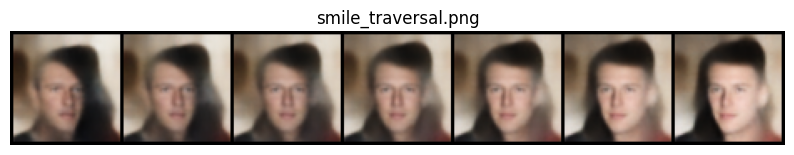

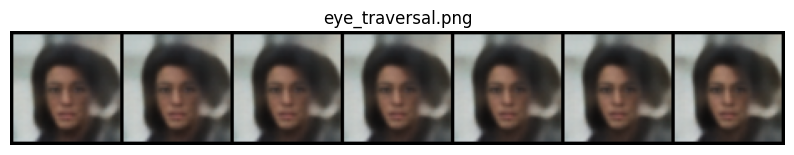

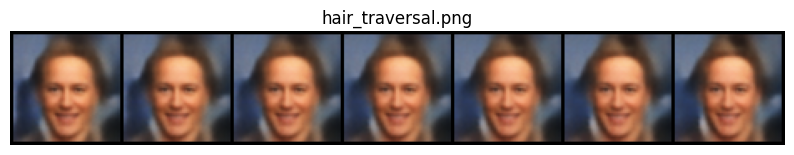

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for fname in ["smile_traversal.png", "eye_traversal.png", "hair_traversal.png"]:
    img = mpimg.imread(f"{OUT_DIR}/{fname}")
    plt.figure(figsize=(10, 2))
    plt.imshow(img)
    plt.axis("off")
    plt.title(fname)
    plt.show()


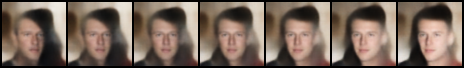

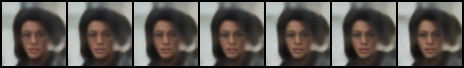

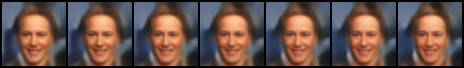

In [16]:
from IPython.display import Image, display

# show one image
display(Image(filename=f"{OUT_DIR}/smile_traversal.png"))
display(Image(filename=f"{OUT_DIR}/eye_traversal.png"))
display(Image(filename=f"{OUT_DIR}/hair_traversal.png"))
